In [1]:
using Revise

In [1]:
#using LinearMaps

In [2]:
using LinearAlgebra
import LinearAlgebra: ldiv!, mul!, *, \

In [2]:
using ViscousFlow

In [2]:
using Plots
pyplot()
clibrary(:colorbrewer)
default(grid = false)

## New functions

In [5]:
struct SaddleSystem{T,Ns,Nc}
    A :: LinearMap{T}
    B₂ :: LinearMap{T}
    B₁ᵀ :: LinearMap{T}
    C :: LinearMap{T}
    A⁻¹ :: LinearMap{T}
    A⁻¹B₁ᵀf :: Vector{T}
    B₂A⁻¹r₁ :: Vector{T}
    _u_buf :: Vector{T}
    _f_buf :: Vector{T}
    S :: LinearMap{T}
    S⁻¹ :: LinearMap{T}
end

In [6]:
function SaddleSystem(A::LinearMap{T},B₂::LinearMap{T},B₁ᵀ::LinearMap{T},C::LinearMap{T},
                      A⁻¹::LinearMap{T}) where {T}
    
    ns, nc = _check_sizes(A,B₂,B₁ᵀ,C)
    
    S = C - B₂*A⁻¹*B₁ᵀ
    #S = LinearMap{Float64}(x -> C*x - B₂*(A⁻¹*(B₁ᵀ*x)),length(f));
    Sfact = factorize(Matrix(S))
    S⁻¹ = LinearMap{T}(x -> Sfact\x,nc)
    
    return SaddleSystem{T,ns,nc}(A,B₂,B₁ᵀ,C,A⁻¹,zeros(T,ns),zeros(T,nc),zeros(T,ns),zeros(T,nc),S,S⁻¹)
end

SaddleSystem

In [7]:
function _check_sizes(A,B₂,B₁ᵀ,C)
    mA, nA = size(A)
    mB1, nB1 = size(B₁ᵀ)
    mB2, nB2 = size(B₂)
    mC, nC = size(C)
    
    # check compatibility of sizes
    mA == nA  || error("A is not square")
    mA == mB1 || error("Incompatible number of rows in A and B₁ᵀ")
    nA == nB2 || error("Incompatible number of columns in A and B₂")
    mC == mB2 || error("Incompatible number of rows in C and B₂")
    nC == nB1 || error("Incompatible number of columns in C and B₁ᵀ")
    
    ns = nA
    nc = nB1
    
    return ns, nc
end

_check_sizes (generic function with 1 method)

### Constructors

In [111]:
"""
    SaddleSystem

Construct a saddle-point system operator from the constituent operator blocks. The resulting object can be used
with `*` and `\` to multiply and solve. The saddle-point problem has the form

``
\\begin{bmatrix}A & B_1^T \\\\ B_2 & C \\end{bmatrix} \\begin{pmatrix} u \\\\ f \\end{pmatrix} = \\begin{pmatrix} r_1 \\\\ r_2 \\end{pmatrix}
``

### Constructors
- `SaddleSystem(A::AbstractMatrix,B₂::AbstractMatrix,B₁ᵀ::AbstractMatrix,C::AbstractMatrix)`.
Blocks are given as matrices. Must have consistent sizes to stack appropriately.
- `SaddleSystem(A,B₂,B₁ᵀ,C,u,f)`.
Operators `A`, `B₂`, `B₁ᵀ`, `C` are given in various forms, including matrices, functions, and function-like objects.
`u` and `f` are examples of the data types in the corresponding solution and right-hand side vectors.
The entries `A` and `B₂` must be able to act upon `u` (either by multiplication or as a function) and `B₁ᵀ` and `C` must be able to act on `f`
(either by multiplication or as a function).
- `SaddleSystem(A,B₂,B₁ᵀ)` or `SaddleSystem(A,B₂,B₁ᵀ,u,f)`.
The `C` block is omitted and assumed to be zero.
"""
function SaddleSystem(A::AbstractMatrix{T},B₂::AbstractMatrix{T},B₁ᵀ::AbstractMatrix{T},
                      C::AbstractMatrix{T}) where {T}
    
    Afact = factorize(A)
    Ainv = LinearMap{T}(x -> Afact\x,size(A,1))
    
    return SaddleSystem(LinearMap{T}(A),LinearMap{T}(B₂),LinearMap{T}(B₁ᵀ),
                        LinearMap{T}(C),Ainv)
end

SaddleSystem

In [112]:
?SaddleSystem

search: SaddleSystem SaddlePointSystems



```
SaddleSystem
```

Construct a saddle-point system operator from the constituent operator blocks. The resulting object can be used with `*` and `` to multiply and solve. The saddle-point problem has the form

$\begin{bmatrix}A & B_1^T \\ B_2 & C \end{bmatrix} \begin{pmatrix} u \\ f \end{pmatrix} = \begin{pmatrix} r_1 \\ r_2 \end{pmatrix}$

### Constructors

  * `SaddleSystem(A::AbstractMatrix,B₂::AbstractMatrix,B₁ᵀ::AbstractMatrix,C::AbstractMatrix)`.

Blocks are given as matrices. Must have consistent sizes to stack appropriately.

  * `SaddleSystem(A,B₂,B₁ᵀ,C,u,f)`.

Operators `A`, `B₂`, `B₁ᵀ`, `C` are given in various forms, including matrices, functions, and function-like objects. `u` and `f` are examples of the data types in the corresponding solution and right-hand side vectors. The entries `A` and `B₂` must be able to act upon `u` (either by multiplication or as a function) and `B₁ᵀ` and `C` must be able to act on `f` (either by multiplication or as a function).

  * `SaddleSystem(A,B₂,B₁ᵀ)` or `SaddleSystem(A,B₂,B₁ᵀ,u,f)`.

The `C` block is omitted and assumed to be zero.


In [9]:
# For cases in which C is zero, no need to pass along the argument
SaddleSystem(A::AbstractMatrix{T},B₂::AbstractMatrix{T},B₁ᵀ::AbstractMatrix{T}) where {T} = 
        SaddleSystem(A,B₂,B₁ᵀ,zeros(T,size(B₂,1),size(B₁ᵀ,2)))

SaddleSystem

In [10]:
# This version should take in functions or function-like objects that act upon given
# data types u and f. Should transform them into operators that act on abstract vectors
# of the same size
# There should already be an \ operator associated with A
function SaddleSystem(A,B₂,B₁ᵀ,C,u::TU,f::TF;eltype=Float64) where {TU,TF}
    
    return SaddleSystem(linear_map(A,u,eltype=eltype),linear_map(B₂,u,f,eltype=eltype),
                        linear_map(B₁ᵀ,f,u,eltype=eltype),
                        linear_map(C,f,eltype=eltype),
                        linear_inverse_map(A,u,eltype=eltype))
end

SaddleSystem

In [166]:
SaddleSystem(A,B₂,B₁ᵀ,u::TU,f::TF;eltype=Float64) where {TU,TF} = SaddleSystem(A,B₂,B₁ᵀ,zeros(eltype,length(f),length(f)),u,f,eltype=eltype)

SaddleSystem

Use cases:
- All operators are matrices and u and f are vectors.
- Operators are functions or function-like objects, and u and f are wrappers for vectors
- A is itself a SaddleSystem (but the rest of the operators are functions or matrices) and u is a tuple.

Should transform any type of `u` and `f` into a pair of vectors.

In [230]:
test_args4((5,(3,4,[3,2])),[2,3])

(5, (3, 4, [3, 2]))
[2, 3]
[5, 3, 4, 3, 2][2, 3]


In [245]:
v1, v2 = test_args4((w,w),(w,f));

In [253]:
v = Iterators.flatten((w,(w,f)));

In [256]:
typeof((1,2)) <: AbstractArray

false

### Arithmetic operations

In [12]:
function mul!(output::Tuple{AbstractVector{T},AbstractVector{T}},sys::SaddleSystem{T,Ns,Nc},input::Tuple{AbstractVector{T},AbstractVector{T}}) where {T,Ns,Nc}
    u,f = input 
    r₁,r₂ = output
    length(u) == length(r₁) == Ns || error("Incompatible number of elements")
    length(f) == length(r₂) == Nc || error("Incompatible number of elements")
    
    r₁ .= sys.A*u + sys.B₁ᵀ*f
    r₂ .= sys.B₂*u + sys.C*f
    return output
end

mul! (generic function with 196 methods)

In [13]:
function mul!(sol::Tuple{TU,TF},sys::SaddleSystem,rhs::Tuple{TU,TF}) where {T,Ns,Nc,TU,TF}
    u, f = sol
    r₁, r₂ = rhs
    return mul!((_unwrap_vec(u),_unwrap_vec(f)),sys,(_unwrap_vec(r₁),_unwrap_vec(r₂)))
end

mul! (generic function with 197 methods)

In [14]:
function (*)(sys::SaddleSystem,input::Tuple)
    u, f = input
    output = (similar(u),similar(f))
    mul!(output,sys,input)
    return output 
end

* (generic function with 497 methods)

In [15]:
# Routine for accepting vector inputs, parsing it into Ns and Nc parts
function mul!(sol::AbstractVector{T},sys::SaddleSystem{T,Ns,Nc},rhs::AbstractVector{T}) where {T,Ns,Nc}
    mul!(_split_vector(sol,Ns,Nc),sys,_split_vector(rhs,Ns,Nc))
    return sol
end

mul! (generic function with 198 methods)

In [16]:
function (*)(sys::SaddleSystem,input::AbstractVector)
    output = similar(input)
    mul!(output,sys,input)
    return output 
end

* (generic function with 498 methods)

In [17]:
function ldiv!(sol::Tuple{AbstractVector{T},AbstractVector{T}},sys::SaddleSystem{T,Ns,Nc},rhs::Tuple{AbstractVector{T},AbstractVector{T}}) where {T,Ns,Nc}
    
    N = Ns+Nc
    u,f = sol #_split_vector(sol,Ns,Nc)
    r₁,r₂ = rhs #_split_vector(rhs,Ns,Nc)
    length(u) == length(r₁) == Ns || error("Incompatible number of elements")
    length(f) == length(r₂) == Nc || error("Incompatible number of elements")

    u .= sys.A⁻¹*r₁

    sys.B₂A⁻¹r₁ .= sys.B₂*u
    sys._f_buf .= r₂
    sys._f_buf .-= sys.B₂A⁻¹r₁
    
    if Nc > 0
        f .= sys.S⁻¹*sys._f_buf
        #f .= sys.P(f)
    end
    sys.A⁻¹B₁ᵀf .= sys.A⁻¹*sys.B₁ᵀ*f
    u .-= sys.A⁻¹B₁ᵀf
    
    return sol
end

ldiv! (generic function with 125 methods)

In [18]:
function ldiv!(sol::Tuple{TU,TF},sys::SaddleSystem,rhs::Tuple{TU,TF}) where {T,Ns,Nc,TU,TF}
    u, f = sol
    r₁, r₂ = rhs
    return ldiv!((_unwrap_vec(u),_unwrap_vec(f)),sys,(_unwrap_vec(r₁),_unwrap_vec(r₂)))
end

ldiv! (generic function with 126 methods)

In [19]:
function (\)(sys::SaddleSystem,input::Tuple) where {T,Ns,Nc}
    u, f = input
    sol = (similar(u),similar(f))
    ldiv!(sol,sys,input)
    return sol
end

\ (generic function with 191 methods)

In [20]:
# Routine for accepting vector inputs, parsing it into Ns and Nc parts
function ldiv!(sol::AbstractVector{T},sys::SaddleSystem{T,Ns,Nc},rhs::AbstractVector{T}) where {T,Ns,Nc}
    ldiv!(_split_vector(sol,Ns,Nc),sys,_split_vector(rhs,Ns,Nc))
    return sol
end

ldiv! (generic function with 127 methods)

In [21]:
function (\)(sys::SaddleSystem,input::AbstractVector)
    sol = similar(input)
    ldiv!(sol,sys,input)
    return sol 
end

\ (generic function with 192 methods)

### Auxiliary routines

In [22]:
# vector -> tuple
function _split_vector(x,Ns,Nc)
    return view(x,1:Ns), view(x,Ns+1:Ns+Nc)
end

_split_vector (generic function with 1 method)

In [164]:
# for a given function of function-like object A, which acts upon data of type u
# and returns data of type f
# return a LinearMap that acts upon a vector form of u
linear_map(A,u,f;eltype=Float64) = _linear_map(A,u,f,eltype)
linear_map(A,u;eltype=Float64) = _linear_map(A,u,eltype)
linear_map(A::AbstractMatrix{T},u::AbstractVector{T};eltype=Float64) where {T} = LinearMap{eltype}(A)
linear_map(A::SaddleSystem{T,Ns,Nc},::Any;eltype=Float64) where {T,Ns,Nc} = LinearMap{T}(x->A*x,Ns+Nc)

linear_map (generic function with 5 methods)

In [163]:
function linear_inverse_map(A,input;eltype=Float64)
    hasmethod(\,Tuple{typeof(A),typeof(input)}) || error("No such backslash operator exists")
    return LinearMap{eltype}(_create_vec_backslash(A,input),length(input))
end
linear_inverse_map(A::SaddleSystem{T,Ns,Nc},::Any;eltype=Float64) where {T,Ns,Nc} = LinearMap{T}(x->A\x,Ns+Nc)

linear_inverse_map (generic function with 2 methods)

In [25]:
_linear_map(A,input,output,eltype) = LinearMap{eltype}(_create_fcn(A,input),length(output),length(input))
_linear_map(A,input,eltype) = LinearMap{eltype}(_create_fcn(A,input),length(input))

_linear_map (generic function with 2 methods)

In [26]:
function _create_fcn(A,input)
    if hasmethod(*,Tuple{typeof(A),typeof(input)})
        fcn = _create_vec_multiplication(A,input)
    elseif hasmethod(A,Tuple{typeof(input)})
        fcn = _create_vec_function(A,input)
    end
    return fcn
end

_create_fcn (generic function with 1 method)

In [27]:
_create_vec_multiplication(A,u::TU) where {TU} = (x -> vec(A*_wrap_vec(x,u)))
_create_vec_function(A,u::TU) where {TU} = (x -> vec(A(_wrap_vec(x,u))))
_create_vec_backslash(A,u::TU) where {TU} = (x -> vec(A\_wrap_vec(x,u)))

_create_vec_backslash (generic function with 1 method)

In [28]:
_wrap_vec(x::Vector{T},u::TU) where {T,TU} = TU(reshape(x,size(u)...))
_wrap_vec(x::Base.ReshapedArray,u::TU) where {TU} = parent(x)
_wrap_vec(x::AbstractVector{T},u::TU) where {T,TU} = x
_wrap_vec(x,u::TU) where {TU <: Tuple} = x

_wrap_vec (generic function with 4 methods)

In [29]:
_unwrap_vec(x) = vec(x)
_unwrap_vec(x::Tuple) = x

_unwrap_vec (generic function with 2 methods)

## Test of unconstrained systems

In [2]:
using Pkg
pkg"test ViscousFlow"

   Testing ViscousFlow
 Resolving package versions...
Test Summary:        | Pass  Total
Saddle-Point Systems |   16     16
   Testing ViscousFlow tests passed 


In [128]:
using LinearMaps

In [138]:
Lnull = LinearMap(x -> typeof(w)(),5,0)

LinearMaps.FunctionMap{Float64}(#11, 5, 0; ismutating=false, issymmetric=false, ishermitian=false, isposdef=false)

In [139]:
Lnull*[]

Nodes{Dual,130,130,Float64} data
Printing in grid orientation (lower left is (1,1))
130×130 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0

In [125]:
function testarg(x::Union{Some{T},Nothing}) where {T}
    x != nothing ? println(x) : nothing
end

testarg (generic function with 2 methods)

In [126]:
testarg(rf)

### Test on matrices

In [35]:
A1 = Float64[1 2; 2 1]
B2 = Float64[2 3;-1 -1]
B1 = Float64[2 3;-1 -1]'
C = Matrix{Float64}(undef,2,2)
C.= [5 -2; 3 -4];

In [36]:
A = SaddleSystem(A1,B2,B1,C);

In [37]:
rhs = ([1.0,2.0],[3.0,4.0]);
sol = (zeros(2),zeros(2));

In [7]:
using LinearAlgebra

In [44]:
norm((A*sol2)[2]-rhs[2])

0.0

In [38]:
@time ldiv!(sol,A,rhs)

  0.000032 seconds (20 allocations: 912 bytes)


([-4.440892098500626e-16, -0.35714285714285704], [0.6428571428571431, -0.42857142857142827])

In [39]:
@time sol2 = A\rhs

  0.000033 seconds (23 allocations: 1.109 KiB)


([-4.440892098500626e-16, -0.35714285714285704], [0.6428571428571431, -0.42857142857142827])

In [51]:
using Pkg
pkg"test ViscousFlow"

   Testing ViscousFlow
 Resolving package versions...
Test Summary:        | Pass  Total
Saddle-Point Systems |    6      6
   Testing ViscousFlow tests passed 


#### Test with vector inputs/outputs

In [12]:
rhs1, rhs2 = rhs
rhsvec = [rhs1;rhs2]
solvec = similar(rhsvec);

In [13]:
solvec = A\rhsvec;

In [14]:
A*solvec

4-element Array{Float64,1}:
 0.9999999999999999
 1.9999999999999998
 3.0               
 4.0               

### Test on ViscousFlow operators

In [17]:
nx = 130; ny = 130;
Lx = 2.0;
dx = Lx/(nx-2);
w = Nodes(Dual,(nx,ny));
u = similar(w);

In [18]:
wvec = vec(w);

In [19]:
L = plan_laplacian(size(w),with_inverse=true)

Discrete Laplacian (and inverse) on a (nx = 130, ny = 130) grid acting on Float64 data with spacing 1.0

In [20]:
w .= rand(size(w)...);

In [21]:
uvec = zeros(length(w));

In [46]:
@time _wrap_vec(wvec,w);

  0.002282 seconds (2.47 k allocations: 151.332 KiB)


In [257]:
Lop = linear_map(L,w);

In [49]:
@time u = L*w;

  0.000128 seconds (8 allocations: 132.344 KiB)


In [51]:
@time uvec = Lop*wvec;

  0.000130 seconds (9 allocations: 132.391 KiB)


In [52]:
_wrap_vec(uvec,u) == u

true

In [53]:
Linv = linear_inverse_map(L,w);

In [56]:
@time yvec = Linv*wvec;

  0.001007 seconds (9 allocations: 132.391 KiB)


In [55]:
@time y = L\w;

  0.001261 seconds (70 allocations: 139.250 KiB)


In [57]:
_wrap_vec(yvec,y) == y

true

In [89]:
n = 128;
θ = range(0,stop=2π,length=n+1);
R = 0.5;
xb = 1.0 .+ R*cos.(θ[1:n])
yb = 1.0 .+ R*sin.(θ[1:n])
ds = (2π/n)*R;
X = VectorData(xb,yb);
f = ScalarData(X);

In [59]:
fvec = vec(f);

In [23]:
E = Regularize(X,dx;issymmetric=true)
Hmat,Emat = RegularizationMatrix(E,f,w);

In [61]:
f[10] = 1.0;

In [62]:
Hop = linear_map(Hmat,f,w);

In [63]:
@time y = Hmat*f;

  0.200185 seconds (1.12 M allocations: 53.199 MiB, 10.72% gc time)


In [64]:
@time yvec = Hop*fvec;

  0.016583 seconds (31.83 k allocations: 1.899 MiB)


In [65]:
_wrap_vec(yvec,y) == y

true

In [66]:
Eop = linear_map(Emat,w,f);

In [67]:
@time g = Emat*w;

  0.021927 seconds (54.80 k allocations: 2.857 MiB)


In [68]:
@time gvec = Eop*vec(w);

  0.006511 seconds (9.90 k allocations: 553.807 KiB)


In [69]:
_wrap_vec(gvec,g) == g

true

In [81]:
@time A = SaddleSystem(L,Emat,Hmat,w,f);

  0.240449 seconds (4.19 k allocations: 67.353 MiB, 23.47% gc time)


In [82]:
@time A.S*vec(f);

  0.001330 seconds (34 allocations: 533.844 KiB)


In [83]:
@time A.S⁻¹*vec(f);

  0.000046 seconds (5 allocations: 1.297 KiB)


In [84]:
sol = (vec(zero(w)),vec(zero(f)));

In [85]:
rhs = (vec(w),vec(f));

In [86]:
@time ldiv!(sol,A,rhs);

  0.001909 seconds (39 allocations: 663.719 KiB)


In [90]:
ψb = ScalarData(X);
w = Nodes(Dual,(nx,ny));
ψb .= -(xb .- 1);
f .= ones(Float64,n)*ds;
ψ = Nodes(Dual,w);

In [88]:
sol2 = (zero(w),zero(f));
@time ldiv!(sol2,A,(w,ψb));

  0.002734 seconds (44 allocations: 663.906 KiB)


In [96]:
@time ψ,f = A\(w,ψb);

  0.002229 seconds (53 allocations: 797.344 KiB)


In [62]:
sol2[1]==ψ

true

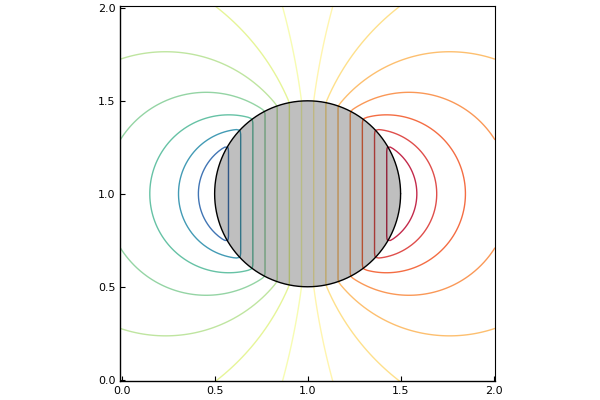

In [29]:
xg,yg = coordinates(ψ,dx=dx)
plot(xg,yg,ψ)
plot!(xb,yb,xlim=(-Inf,Inf),ylim=(-Inf,Inf),fillcolor=:black,fillrange=0,fillalpha=0.25,linecolor=:black)

In [92]:
rhs2 = (similar(w),similar(f));
@time rhs2 = A*sol2;

  0.000582 seconds (35 allocations: 533.797 KiB)


In [93]:
norm(rhs2[2]-ψb)

3.901939054546046e-15

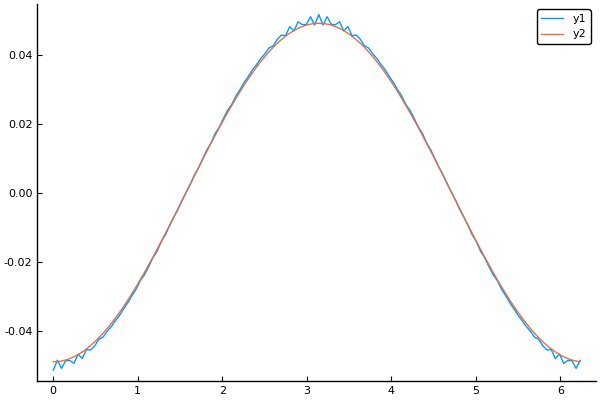

In [99]:
plot(θ[1:n],f)
plot!(θ[1:n],-2*cos.(θ[1:n])*ds)

In [101]:
norm(f/ds+2*cos.(θ[1:n]))

0.41462740654806

In [102]:
pkg"test ViscousFlow"

   Testing ViscousFlow
 Resolving package versions...
Test Summary:        | Pass  Total
Saddle-Point Systems |   16     16
   Testing ViscousFlow tests passed 


### Saddle system of a saddle system

In [64]:
A1 = Float64[1 2; 2 1]
B21 = Float64[2 3];
B11 = B21';
C1 = Matrix{Float64}(undef,1,1)
C1.= 5

B22 = Float64[-1 -1 3];
B12 = Float64[-1 -1 -2]';
C2 = Matrix{Float64}(undef,1,1)
C2.= -4;

In [65]:
rhs11 = [1.0,2.0];
rhs12 = Vector{Float64}(undef,1)
rhs12 .= 3.0;
#rhs1 = (rhs11,rhs12)
rhs1 = [rhs11;rhs12];

rhs2 = Vector{Float64}(undef,1)
rhs2 .= 4.0;

#sol = ((zero(rhs11),zero(rhs12)),zero(rhs2))
rhs = (rhs1,rhs2);
sol = (zero(rhs1),zero(rhs2));

In [66]:
A = SaddleSystem(A1,B21,B11,C1);

In [67]:
Abig = SaddleSystem(A,B22,B12,C2,rhs1,rhs2);

In [68]:
sol = Abig\rhs

([-4.440892098500626e-16, -0.3571428571428571, 0.6428571428571432], [-0.4285714285714282])

In [70]:
out = Abig*sol

([1.0, 1.9999999999999998, 3.0000000000000004], [4.0])

In [75]:
norm(out[1]-rhs1)

4.965068306494546e-16

#### Pass in as tuples of tuples

In [152]:
rhs11 = [1.0,2.0];
rhs12 = Vector{Float64}(undef,1)
rhs12 .= 3.0
rhs1 = (rhs11,rhs12)

rhs2 = Vector{Float64}(undef,1)
rhs2 .= 4.0;

rhs = (rhs1,rhs2)

sol = ((zero(rhs11),zero(rhs12)),zero(rhs2))

(([0.0, 0.0], [0.0]), [0.0])

In [154]:
A = SaddleSystem(A1,B21,B11,C1);

In [162]:
x -> x...

ErrorException: syntax: "..." expression outside call

In [155]:
Abig = SaddleSystem(A,B22,B12,C2,rhs1,rhs2);

here 1


UndefVarError: UndefVarError: fcn not defined

In [351]:
linear_map(B22,rhs1)

UndefVarError: UndefVarError: fcn not defined

In [353]:
rhs1

([1.0, 2.0], [3.0])

In [352]:
B22

1×3 Array{Float64,2}:
 -1.0  -1.0  3.0

In [ ]:
function tuple_to_vec(x::Tuple)
    
end

In [355]:
x1 = rand(456)
x2 = rand(543);

In [356]:
(x1,x2)

([0.3324135377751545, 0.0637830903880976, 0.05207827662649711, 0.573186766492237, 0.6207517242301448, 0.829538538541734, 0.12178943745390591, 0.478844506511219, 0.43420681511429926, 0.6246309619469748  …  0.12201756154466548, 0.02434998340844996, 0.72667105238494, 0.37302590413474057, 0.9217709542366839, 0.0576457364983225, 0.7077715517705792, 0.5095775140989565, 0.3320877283196395, 0.6922338496082026], [0.8771719858775233, 0.9455817052896689, 0.6811010426407191, 0.44986327330244946, 0.939307956190653, 0.6228116800334988, 0.46701257314879663, 0.3999420626211425, 0.09340186885333912, 0.970951324374415  …  0.768356111373294, 0.6832200904635619, 0.22144365516021147, 0.5973853868795662, 0.07702711794771022, 0.0027832589064189506, 0.07318032463872837, 0.43230150587862615, 0.432005266233209, 0.203806128343333])

In [368]:
@time y = collect(Iterators.flatten([x1,x2]));

  0.000023 seconds (16 allocations: 16.656 KiB)


In [379]:
@time y = reduce(vcat,(x1,(x1,x2)));

  0.000042 seconds (479 allocations: 11.719 KiB)


457-element Array{Any,1}:
 0.3324135377751545                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
 0.0637830903880976                                                                                                                                        